### Волновое уравнение в двух измерениях
Наша цель - вычислить и визуализировать решения $u(x,y, t)$ волнового уравнения $$u_{tt}=c ^ 2 \Delta u$$ с $\Delta u =u_{xx} +u_{yy}$ в квадрате $(x,y)\in[0,L]\times[0,L]$ с начальными условиями $u(x,y,0)=f(x,y)$ и $u_t(x,y,0)=g(x,y)$. Наш код позволит нам использовать граничные условия Дирихле, Неймана или периодические. [По ссылке приведен видеоролик о легком дожде, падающем в пруд](https://youtu.be/d1GSHAMpNYo ). Сначала мы загружаем необходимые модули Python.

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from matplotlib.colors import LightSource

Далее мы определяем следующие функции:
* `discrete_laplacian` обеспечивает центрированную конечно-разностную аппроксимацию оператора Лапласа $\Delta u =u_{xx}+u_{yy}$;
* `leapfrog" реализует метод leapfrog для разработки решения во времени. Чехарда использует тот факт, что волновое уравнение содержит производные второго порядка по времени;
* `define_initial_condition` использует заданные начальные условия для вычисления первых двух итераций решения;
* `update_solution` использует метод чехарды, применяемый к производной по времени $u_{tt}$, чтобы обновить решение до следующего временного шага;
* `update_graph` анимирует решение.

In [ ]:
def discrete_laplacian(u, bdy):
    if bdy == 'Periodic':
        L = -4*u
        L += np.roll(u, (0,-1), (0,1))
        L += np.roll(u, (0,+1), (0,1))
        L += np.roll(u, (-1,0), (0,1))
        L += np.roll(u, (+1,0), (0,1))
        return L
    elif bdy == 'Dirichlet':
        v = np.pad(u, 1, constant_values=0)
    elif bdy == 'Neumann':
        v = np.pad(u, 1, mode='edge')
    L = -4*v
    L += np.roll(v, (0,-1), (0,1))
    L += np.roll(v, (0,+1), (0,1))
    L += np.roll(v, (-1,0), (0,1))
    L += np.roll(v, (+1,0), (0,1))
    L = L[1:-1,1:-1]
    return L

def leapfrog(u0, um, cfl, bdy):
    up = 2*u0 - um + cfl**2*discrete_laplacian(u0, bdy)
    return up, u0

def define_initial_condition(f, g, dt, bdy):
    u0 = f + 0.5*cfl**2*discrete_laplacian(f, bdy) + dt*g
    return u0, f

def update_solution(f, g, cfl, dt, bdy, Nframes, Nskip):
    n = 0
    u0, um = define_initial_condition(f, g, dt, bdy)
    while n<Nframes:
        n += 1
        for k in range(Nskip):
            u0, um = leapfrog(u0, um, cfl, bdy)
        yield u0

def update_graph(u, ls, imu):
    imu.set_array(ls.hillshade(u))

В следующей ячейке мы определяем константу скорости $c>0$, задаем начальные условия $u(x,0)=f(x)$ и $u_t(x,0)=g(x)$ и запускаем анимацию решения.

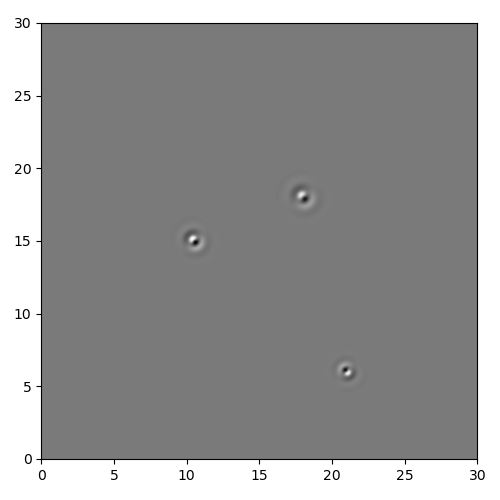

In [5]:
# параметр модели
c = 1       # постоянная скорость
L = 30      # длина домена

# числовые параметры
N = 800    # размер сетки

# определите функцию
def pebble(X, Y, width, positionX, positionY):
    r = width*np.sqrt((X-positionX)**2 + (Y-positionY)**2)
    u = np.random.uniform(-1., 1., 1)*np.cos(1.9*r)/np.cosh(r)
    return u

x = np.linspace(0, L, N)
X, Y = np.meshgrid(x, x)

# начальное смещение состоит из трех отдельных капель дождя
f =  pebble(X, Y, 3.5, 0.35*L, 0.5*L)
f += pebble(X, Y, 3, 0.6*L, 0.6*L)
f += pebble(X, Y, 4, 0.7*L, 0.2*L)

# начальная скорость равна нулю
g = np.zeros((N,N))

# параметры анимации
Nsteps = 400
Nskip = 10

# установите временной шаг для удовлетворения критерия стабильности скачкообразного изменения (cfl < 1/sqrt(2) ~ 0,7)
cfl = 0.6
dx = L/N
dt = cfl * dx / c

# вычислительное и анимационное решение
Nframes = int(Nsteps/Nskip)
extent = [0, L, 0, L]

fig, ax = plt.subplots(1,1,figsize=(5,5))
ls = LightSource(azdeg=220, altdeg=70)
imu = ax.imshow(ls.hillshade(f), cmap='Greys', animated=True, extent=extent, origin='lower')
ani = animation.FuncAnimation(fig, update_graph,
                              update_solution(f, g, cfl, dt, 'Neumann', Nframes, Nskip),
                              fargs=(ls, imu), repeat=False)
plt.tight_layout()
plt.show()